## A Introduction to Forecasting With Univariate Models

In [78]:
# 导入需要的包
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from scipy import stats

### Example 7.1

读入数据，并做图查看。


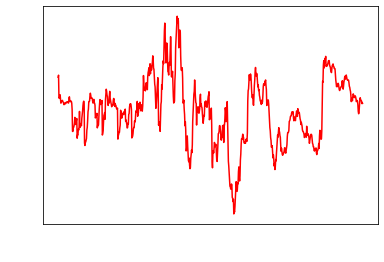

In [49]:
data1=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/r20.csv")
data2=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/rs.csv")
data=data1['r20']-data2['rs']
data=data.dropna(axis=0,how='all')
ts=np.zeros(len(data))
for i in range(len(data)):
    ts[i]=data[i]
plt.plot(ts,'r')
plt.ylabel('r20-rs',color="white")
plt.xlabel('time',color="white")
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

In [6]:
# AR(2)参数估计
resultAR = AutoReg(ts, 2).fit()
resultAR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  786
Model:                     AutoReg(2)   Log Likelihood                -381.018
Method:               Conditional MLE   S.D. of innovations              0.393
Date:                Fri, 07 Aug 2020   AIC                             -1.856
Time:                        15:10:54   BIC                             -1.832
Sample:                             2   HQIC                            -1.847
                                  786                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0358      0.017      2.124      0.034       0.003       0.069
y.L1           1.1928      0.035     34.277      0.000       1.125       1.261
y.L2          -0.2242      0.035     -6.448      0.000      -0.292      -0.156
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0427           +0.0000j            1.0427            0.0000
AR.2            4.2767           +0.0000j            4.2767            0.0000
-----------------------------------------------------------------------------
"""

使用AR(2)估计得到的模型是x[t]=0.036+1.193*x[t-1]-0.224*x[t-2]+a[t]，根据序列的最后两个观察值x[T-1]=1.69和x[T]=1.63，可以预测未来三天的数据

In [14]:
T=len(ts)-1
f=[0,0,0]
f[0]=0.036+1.193*ts[T]-0.224*ts[T-1]
f[1]=0.036+1.193*f[0]-0.224*ts[T]
f[2]=0.036+1.193*f[1]-0.224*f[0]
print("The forecast of the following 3 period:",f)

The forecast of the following 3 period: [1.60203, 1.5821017900000003, 1.5645927154700003]


随着预测步长的增加，最终的预测值将会趋近于样本均值1.195，

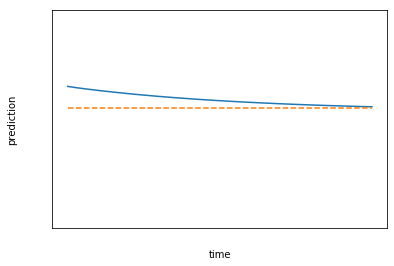

In [36]:
prediction=resultAR.predict(786,826)
plt.plot(prediction)
plt.plot([1.195]*len(prediction),linestyle='--')
plt.ylabel('prediction')
plt.xlabel('time')
plt.ylim(-1, 3)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

权重可以通过如下公式计算：

In [19]:
phi1=1.193
phi2=-0.224
PHI=[0,0,0,0]
PHI[0]=phi1
PHI[1]=phi1**2+phi2
PHI[2]=phi1**3+2*phi1*phi2
PHI[3]=phi1**4+3*phi1**2*phi2+phi2**2
for i in range(len(PHI)):
    print('PHI[{}]={}'.format(i,PHI[i]))

PHI[0]=1.193
PHI[1]=1.1992490000000002
PHI[2]=1.1634720570000001
PHI[3]=1.1193903880010003


由于白噪声的方差是0.393，因此可以计算出预测误差的方差如下：

In [23]:
V=[0,0,0,0]
V[0]=0.393**2
V[1]=0.393**2*(1+PHI[0]**2)
V[2]=0.393**2*(1+PHI[0]**2+PHI[1]**2)
V[3]=0.393**2*(1+PHI[0]**2+PHI[1]**2+PHI[2]**2)
for i in range(len(V)):
    print('V[{}]={}'.format(i,V[i]))

V[0]=0.154449
V[1]=0.37426838480100005
V[2]=0.5963966530327905
V[3]=0.805469202640553


预测误差的方差最终会收敛到样本方差3.284。

如果用ARIMA(0,1,1)来对上述时间序列进行建模，得到如下结果：

In [38]:
w=data.diff().dropna(axis=0,how='all')
resultAR = AutoReg(w, 1).fit()
resultAR.summary()

D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  785
Model:                     AutoReg(1)   Log Likelihood                -389.043
Method:               Conditional MLE   S.D. of innovations              0.397
Date:                Fri, 07 Aug 2020   AIC                             -1.838
Time:                        16:05:23   BIC                             -1.820
Sample:                             1   HQIC                            -1.831
                                  785                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0017      0.014     -0.117      0.907      -0.029       0.026
y.L1           0.2090      0.035      5.983      0.000       0.141       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.7857           +0.0000j            4.7857            0.0000
-----------------------------------------------------------------------------
"""

白噪声方差是0.397，如果将差分序列视为AR(1)过程，则AR1的系数是0.209，忽略不显著区别于0的截距。

预测未来数据如下：

In [44]:
np.random.seed(7)
a=np.random.randn(len(data))*0.397
f[0]=data[785]+0.209*a[785]
print("The prediction of the following day:",f[0])

The prediction of the following day: 1.5003965187291681


对所有的h>1，预测值都为1.5，因此预测序列没有收敛到样本均值的趋势。
预测误差的方差可以通过下式计算：

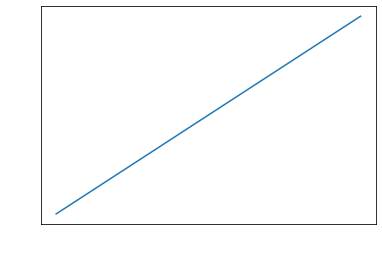

In [48]:
V=[0]*100
for i in range(len(V)):
    V[i]=0.398**2*(1+1.204**2*(i-1))
plt.plot(V)
plt.ylabel('Variance',color="white")
plt.xlabel('time',color="white")
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

可以看出，方差随着预测步长的增加线性无限增长，而不是像AR(2)过程的预测那样，最终收敛于样本方差。

### Examle 7.2

读入数据，按照Example 4.3中用ARIMA(0,1,3)模型拟合数据。

In [50]:
data=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/Global temperature.csv")
ts=data['value']
w=ts.diff().dropna(axis=0,how='all')
resultMA = smt.ARMA(w, order=(0, 3)).fit()
resultMA.summary()

D:\anaconda3\envs\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                 2015
Model:                     ARMA(0, 3)   Log Likelihood                1354.137
Method:                       css-mle   S.D. of innovations              0.124
Date:                Fri, 07 Aug 2020   AIC                          -2698.274
Time:                        17:02:44   BIC                          -2670.233
Sample:                             0   HQIC                         -2687.982
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.001      0.685      0.494      -0.001       0.002
ma.L1.value    -0.5042      0.022    -22.630      0.000      -0.548      -0.461
ma.L2.value    -0.0907      0.026     -3.543      0.000      -0.141      -0.041
ma.L3.value    -0.1165      0.023     -5.088      0.000      -0.161      -0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2504           -0.0000j            1.2504           -0.0000
MA.2           -1.0143           -2.4155j            2.6198           -0.3133
MA.3           -1.0143           +2.4155j            2.6198            0.3133
-----------------------------------------------------------------------------
"""

忽略不显著大于零的截距，可以得到模型如下：x[t]-x[t-1]=a[t]-0.504*a[t-1]-0.09*a[t-2]-0.117*a[t-3]，其中白噪声的方差是0.124，因此可以作出如下预测：

[0.6096555609752963, 0.6213313860565842, 0.6289057176785743, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


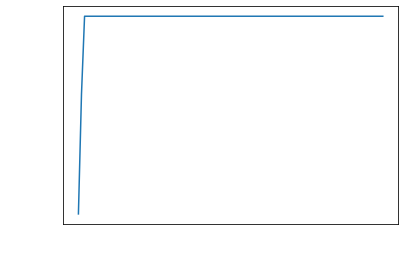

In [73]:
a=np.random.randn(len(data))*0.124
T=len(ts)-1
f=[0]*100
f[0]=ts[T]-0.504*a[T]-0.09*a[T-1]-0.117*a[T-2]
f[1]=f[0]-0.09*a[T]-0.117*a[T-1]
f[2]=f[1]-0.117*a[T]
print(f)
for i in range(2,len(f)):
    f[i]=f[2]
plt.plot(f)
plt.ylabel('prediction',color="white")
plt.xlabel('time',color="white")
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.show()

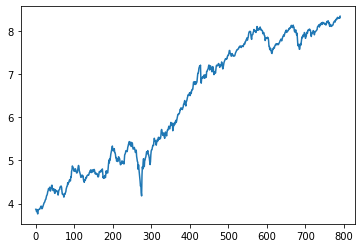

In [87]:
data=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/All Share.csv")
ts=np.log(data['value'])
plt.plot(ts)
plt.show()

拟合得到的模型为：x[t]=3.914+0.006*t+e[t];

其中e[t]=1.106*e[t-1]=0.118*e[t-2]+a[t]。

因此可以通过f_h=3.914+0.006*(T+h)来预测未来的数据

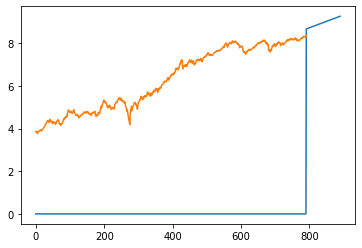

In [91]:
T=len(ts)-1
f=[0]*100
for i in range(len(f)):
    f[i]=3.914+0.006*(T+1+i)
plt.plot([0]*791+f)
plt.plot(ts)
plt.show()